Alright, great job finishing Chapter 2! We've built a solid foundation in regression, where you predicted a *value* (like a house price).

Now, let's move on to **Chapter 3: Classification**. This is a different beast. Instead of predicting a number on a continuous scale, we're going to predict a **class** or a **category**. Think of it like sorting mail into different bins (bin '0', bin '1', bin '2', etc.) rather than estimating the postage cost.

---

# **Our New "Hello, World!" - The MNIST Dataset**
In programming, the first thing we always do is print "Hello, World!". In machine learning, the "Hello, World!" for classification is the **MNIST dataset**.

- **What it is:** A big collection (70,000) of small, 28x28 pixel images.

- **What's in the images:** Handwritten digits (0 through 9) written by high school students and US Census Bureau employees.

- **Why it's famous:** It's a standard benchmark. When someone invents a new classification algorithm, they test it on MNIST to see how it performs against other algorithms. It's the perfect dataset for us to start with.

---

## **Getting the Data with Scikit-Learn**

First, we need to load this dataset. Scikit-Learn has a whole module, `sklearn.datasets`, to help with this. It has three main types of functions:

1. `fetch_*`: Used to download **real-world datasets** from the internet (like `fetch_openml()`). This is what we're using.

2. `load_*`: Used to load **small, toy datasets** that come bundled *with* Scikit-Learn. These are good for quick tests.

3. `make_*`: Used to **generate fake datasets** for testing specific algorithm behaviors.

The code in the book uses `fetch_openml()` to get MNIST:

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

The important part here is `as_frame=False`. By default, this function might give you the data as a Pandas DataFrame. But for images, it's *much* easier to work with NumPy arrays. Setting `as_frame=False` tells Scikit-Learn, "Just give me the raw NumPy data."

---

## **Looking at Our Data (X and y)**
The `mnist` object that's returned is a `Bunch` object, which is like a dictionary. We can grab the two most important pieces:

`mnist.data`: The features (the images themselves). We'll call this `X`.

`mnist.target`: The labels (what digit each image represents). We'll call this `y`.

In [5]:
X, y = mnist.data, mnist.target

Let's look at their shape:

In [6]:
X.shape

(70000, 784)

`X.shape` **is** `(70000, 784)`

This is the most important concept to understand.
- **70,000:** This is easy. It's the number of images in our dataset.
- **784:** Where does this number come from?
  - Each image is $28 \times 28$ pixels.
  - To make it "machine learning friendly," the 2D image has been **"flattened"** into a single 1D row.
  - $28 \times 28 = 784$.
  - So, each row is one image, and each of the 784 columns is the **intensity of a single pixel** (from 0 for white to 255 for black).

In [9]:
y.shape

(70000,)

`y.shape` **is** `(70000,)`

This is a 1D array with 70,000 entries. It's our list of labels. The first entry in `y` ( `y[0]` ) is the correct digit for the first image in `X` ( `X[0]` ).

When you check `y[0]`, the book says it's `'5'`. This tells us the first image in our dataset is supposed to be the digit 5.

---

## **How to "See" a Flattened Image**

We can't make sense of a row of 784 numbers. To prove to ourselves that `X[0]` is really a '5', we have to reverse the flattening. We need to take that 1D array of 784 features and **reshape** it back into its original 2D $28 \times 28$ grid.

That's exactly what the `plot_digit` function does:


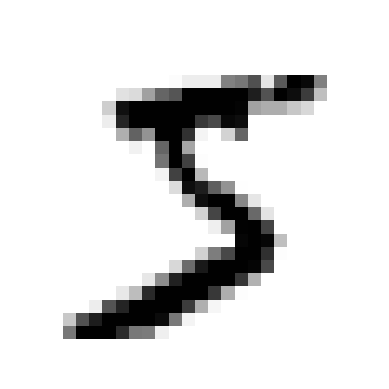

In [18]:
import matplotlib.pyplot as plt

def  plot_digit(image_data):
    # Reshape the 1D array (784, ) into a 2D array (28, 28)
    image = image_data.reshape(28, 28)

    # Use matplotlib's imshow() to display the 2D array as an image
    plt.imshow(image, cmap="binary")
    plt.axis("off")

for i in range (0, 1): # Grab the first image's data
    some_digit = X[i]
    plot_digit(some_digit)
    plt.show()

When you run this, you'll see the image of the handwritten "5".

---

## **The Golden Rule: Create a Test Set First**

This is **critical**. Before you do *any* data exploration or model training, you **must** set aside your test data.

Think of it like an exam. If you study using the *actual* exam questions (the test set), you'll get a perfect score, but you won't have *learned* anything. You'll fail when you see a new, *different* exam.

Your model is the same. It can "cheat" by memorizing the test set's answers (this is called **overfitting**). We must hide the test set and *only* use it for the final evaluation, just once.

Fortunately, the MNIST dataset from `fetch_openml()` is already organized for us:

- **Training set:** The first 60,000 images.

- **Test set:** The last 10,000 images.

So, we can easily split it:

In [19]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

### **A Note on Shuffling**
The book mentions the training set is already shuffled. This is a good thing!

1. It ensures **cross-validation** (which we'll learn about soon) works well. We don't want one "fold" of our data to *only* have 0s and 1s, and another to *only* have 8s and 9s. Shuffling mixes them up.

2. Some algorithms (like Stochastic Gradient Descent) are sensitive to order. They learn poorly if you show them 1,000 pictures of a "5" in a row. Shuffling solves this.

## **Our Mission**
That's the setup! We've moved from regression to classification, we've loaded the famous MNIST dataset, we've understood its 784 features, and we've correctly (and *very* importantly) split it into a training and a test set.

Now we're ready to start building our first classifier. Let's get to it!

---

## **Training a Binary Classifier**

Alright, let's break this down. This is a very important step in our machine learning journey.

We have a big, complicated problem: we want to identify *all* *10* *digits* (0, 1, 2, 3, 4, 5, 6, 7, 8, 9). This is called **multiclass classification**.

But as a smart learning strategy, we're going to start simpler. Instead of building a complex model to sort images into 10 different bins, let's just build a model that sorts them into *two* bins. This is a **binary classifier** ("bi" meaning two).

Our simple question will be:" **"Is this a 5?** (Yes/No).

The two classes (bins) are:

1. **"5"**: This is our *positive* class.

2. **"non-5"**: This is our *negative* class (it includes 0s, 1s, 2s, 3s, 4s, 6s, 7s, 8s, and 9s).

---

### **1. Creating the New "Answer Key"**
Our original "answer key," `y_train`, looks like this: `['5', '0', '4', '1', '9', ...]`. Our new, simple classifier doesn't understand all those digits. It only understands "Yes" or "No" (which we represent with `True` or `False`).

We need to create a new answer key. The code does this very cleverly:

In [20]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Let's look at that first line. It goes through every single label in `y_train` and performs a check: "Is this label equal to `'5'`?"

- If `y_train[0]` is `'5'`, then `y_train_5[0]` becomes `True`.

- If `y_train[1]` is `'0'`, then `y_train_5[1]` becomes `False`.

- If `y_train[2]` is `'4'`, then `y_train_5[2]` becomes `False`.

- ...and so on.

So now, `y_train_5` is our *new* target vector (our new answer key) that looks like: `[True, False, False, ...]`. This is *exactly* what our "5-detector" needs to learn from. We do the same for our test set.

---

### **2. Choosing the Algorithm:** `SGDClassifier`
Now we need to pick a learning algorithm (a "classifier"). The book suggests a great starting point: **Stochastic Gradient Descent (SGD) Classifier.**

Let's break down that name:

- **Classifier:** It classifies things. Easy.

- **Gradient Descent:** This is the "learning" technique. Imagine you're on a foggy mountain and want to find the lowest valley. You check the slope (the "gradient") around you and take a step downhill ("descent"). You repeat this until you're at the bottom. In ML, the "valley" is the point with the *lowest* *error*.

- **Stochastic:** This is the *most* important part. "Stochastic" just means "random." Instead of checking the *entire* mountain's slope (which would mean looking at all 60,000 training images at once!), you just pick **one random training instance* at a time. You look at that single image, calculate the error for *it*, and take a small step downhill. Then you pick another random instance, and so on.

#### **Why is SGD so good?** 
It's incredibly **fast and memory-efficient**. Because it only looks at one instance at a time, you can train it on *massive* datasets (billions of instances!) that would never fit in your computer's RAM. It also makes it possible to do "online learning," where we can keep feeding the model new data as it arrives.

---

### **3. Training the Model (The** `fit` **command)**
This is where the magic happens.

In [22]:

from sklearn.linear_model import SGDClassifier

# 1. We create an instance of the classifier
#    random_state=42 just make sure we get the same "random"
#    start each time, so our result are reproducible
sgd_clf = SGDClassifier(random_state=42)

# 2. We train the model
sgd_clf.fit(X_train, y_train_5)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


The `.fit()` method is the "study" command. We're telling our `sgd_clf`:

- "Here are all the images (`X_train`)."

- "And here is the '5' or 'not-5' answer key for them (`y_train_5`)."

Now, the `SGDClassifier` goes to work. It will loop through the training data (one instance at a time, because it's *stochastic*), making a guess, checking its guess against the `y_train_5` answer, and slightly adjusting its internal parameters to get better. It does this over and over until it has a good model of what separates a "5" from a "non-5".

---

### 4. Making a Prediction (The "Pop Quiz")
The training is done. Our classifier has "studied." Now let's give it a pop quiz. We'll use that `some_digit` variable from before (which was `X[0]`, the image of the '5').

In [ ]:
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

- `sgd_clf.predict(...)`: We're asking our trained classifier to make a prediction.

- `[some_digit]`: We wrap `some_digit` in square brackets `[]` because the `predict` method expects a *list* of images, even if we're only sending one.

- `array([ True])`: This is the classifier's answer! It says, "I predict that this image is in the `True` class." And since `True` means "it's a 5," our classifier got this one right! 🥳

**But hold on!** Just because it got *one* right doesn't mean it's a good model. What if it gets all the *other* ones wrong?

That's why the very next step, as the book says, is to **evaluate its performance** properly. We can't just trust one example.

---
# **Peformance Measure**
---


## **Measuring Accuracy Using Cross-Validation**


